In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sma

#the pca function is written for you, call this from your code to calculate the 1st PC
def pca_function(stdata):
    """Returns the sign identified 1st principal component of a data set.
    input: stdata - a n x t pandas data frame
    output: 1st principal component, standardised to s.d = 1 and
    signed to have the same sign as the cross sectional mean of the variables"""
    factor1_us = sma.PCA(stdata, 1).factors
    factor1 = (factor1_us - factor1_us.mean()) / factor1_us.std()
    sgn = np.sign(pd.concat([stdata.mean(1), factor1], axis=1).corr().iloc[1, 0])
    return factor1 * sgn

#produce your analysis for the following five variables
my_srs = ['INDPRO', 'S&P 500', 'PAYEMS', 'CPIAUCSL', 'BUSINVx']

In [2]:
data_original = pd.read_csv('2021-12.csv',index_col=0)

In [3]:
data_original.dropna(how='all', inplace=True)

In [5]:
data_original = data_original.drop('Transform:')

In [6]:
data_original.index = pd.to_datetime(data_original.index)

# Question 2

In [7]:
data = data_original[data_original.index <='12/01/2019'] 

# Question 3

In [9]:
desc = pd.read_csv('fred_md_desc.csv').dropna(how='all', axis=0)

In [10]:
decs = desc.reset_index(drop = True)

In [11]:
desc = decs.set_index('fred')

In [12]:
desc = desc[desc.index.isin(data.columns) == True]

# Question 4 & 5

In [13]:
tfdata = data.copy()

In [14]:
for srs in tfdata.columns:
    
    if srs == 'VIXCLSx':
        continue
    
    elif desc.loc[srs, 'tcode'] == 2.0:
        tfdata[srs] = tfdata[srs].diff()
        
    elif desc.loc[srs, 'tcode'] == 3.0:
        tfdata[srs] = tfdata[srs].diff().diff()
        
    elif desc.loc[srs, 'tcode'] == 4.0:
        tfdata[srs] = np.log(tfdata[srs])
        
    elif desc.loc[srs, 'tcode'] == 5.0:
        tfdata[srs] = np.log(tfdata[srs]).diff()
        
    elif desc.loc[srs, 'tcode'] == 6.0:
        tfdata[srs] = np.log(tfdata[srs]).diff().diff()
        
    elif desc.loc[srs, 'tcode'] == 7.0:
        tfdata[srs] = (tfdata[srs])/(tfdata[srs].shift(1)-1)
    
    else:
        tfdata[srs] = tfdata[srs]


# Question 6

In [15]:
stdata = tfdata.copy()

In [16]:
stdata = (stdata - stdata.mean()) / stdata.std()

In [17]:
stdata = stdata.fillna(0)

In [18]:
stdata.to_csv('transformed_data.csv',index=True, header=True)

# Question 7

In [19]:
factor1 = pca_function(stdata)

              comp_0
sasdate             
1959-01-01  0.129335
1959-02-01  1.444529
1959-03-01  1.782833
1959-04-01  2.044962
1959-05-01  1.355099
...              ...
2019-08-01 -0.061658
2019-09-01 -0.373838
2019-10-01 -0.527258
2019-11-01  0.320648
2019-12-01 -0.246630

[732 rows x 1 columns]


# Question 8

In [20]:
sns.set_theme()

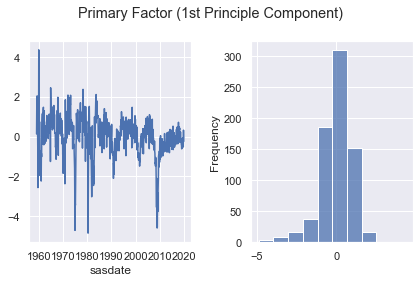

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.lineplot(data=factor1, ax=ax[0],legend=False)
sns.histplot(data=factor1, ax=ax[1],legend=False, bins=10)
plt.ylabel('Frequency')
plt.suptitle('Primary Factor (1st Principle Component)')
plt.tight_layout()

In [24]:
plt.savefig('factor.pdf')

<Figure size 432x288 with 0 Axes>

# Question 9

In [25]:
lag1 = tfdata.shift(1)

# Question 10

In [29]:
factor1_lag1 = factor1.shift(1)
run_dates = lag1[my_srs].dropna().index
fitted_values = pd.DataFrame(index=run_dates,columns=tfdata.columns)
fitted_values = fitted_values[['INDPRO', 'S&P 500', 'PAYEMS', 'CPIAUCSL', 'BUSINVx']]

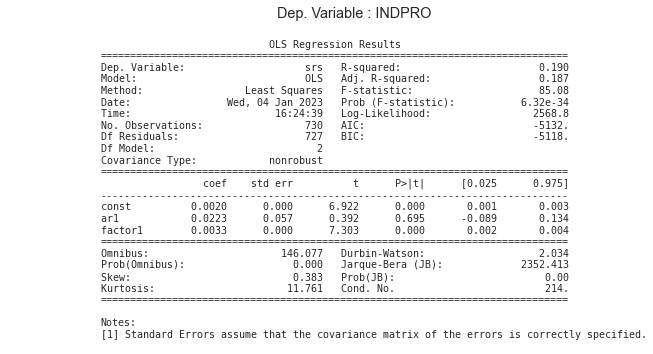

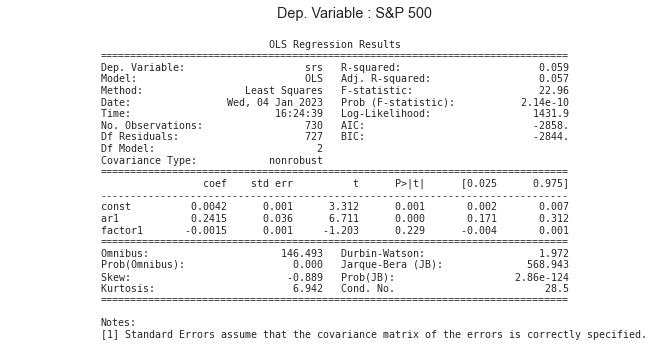

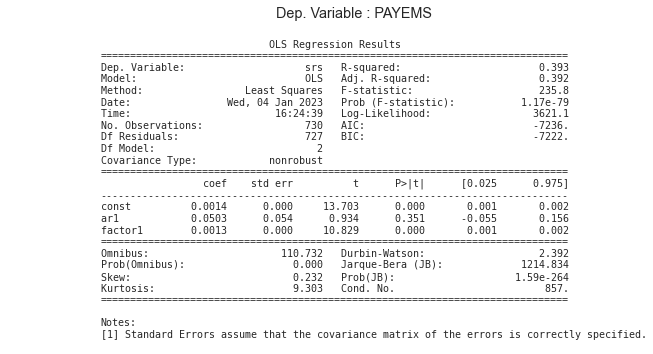

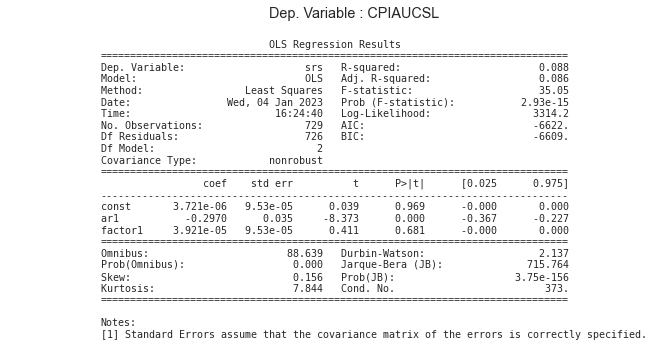

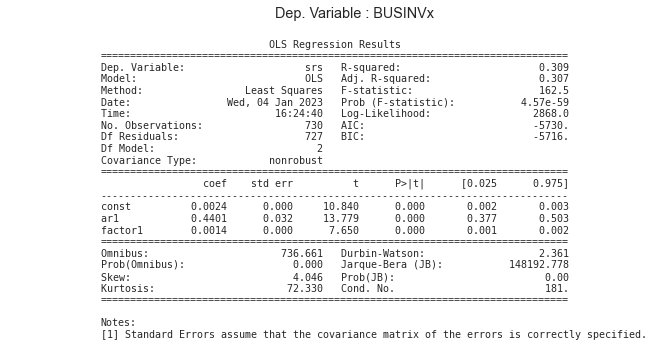

In [30]:
for srs in my_srs:
    reg_data = pd.concat([tfdata[srs],
                         lag1[srs],
                         factor1_lag1],
                        axis=1).set_axis(['srs','ar1','factor1'],axis=1).dropna()
    reg_model = sma.OLS(reg_data['srs'],sma.add_constant(reg_data[['ar1', 'factor1']])).fit()
    summary = reg_model.summary()
    plt.figure(figsize=(10,5))
    plt.rc(srs)
    plt.text(0.15, 0.03, str(summary), {'fontsize': 10}, fontproperties = 'monospace') 
    plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Dep. Variable : ' +srs)
    plt.show( block=False )
    fitted_values[srs]=reg_model.fittedvalues
   
    

# Question 11

In [32]:
fitted_values = fitted_values.dropna()

In [33]:
fitted_values.to_csv('fitted_values.csv')

# Question 12

In [34]:
NBER = pd.read_csv('NBER_DATES.csv', index_col=0)

In [35]:
NBER.index = pd.to_datetime(NBER.index)

In [47]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2


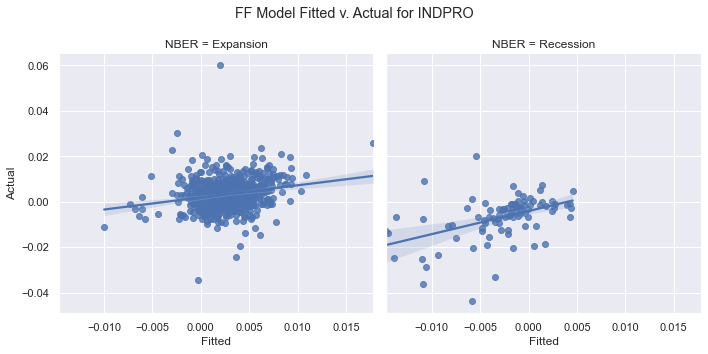

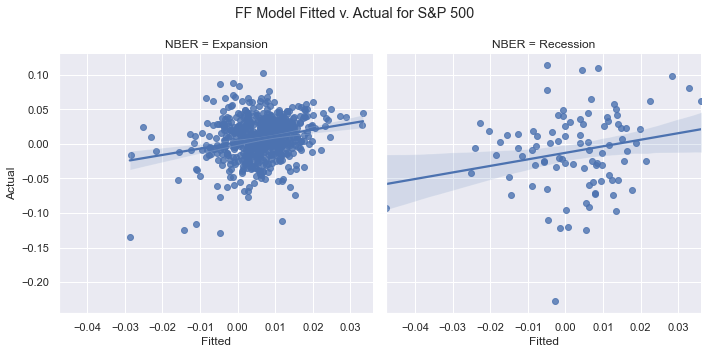

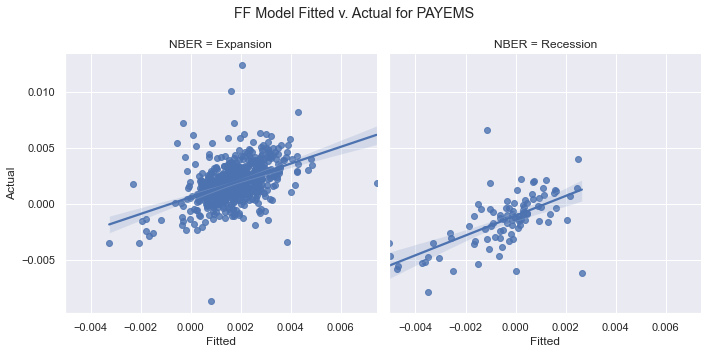

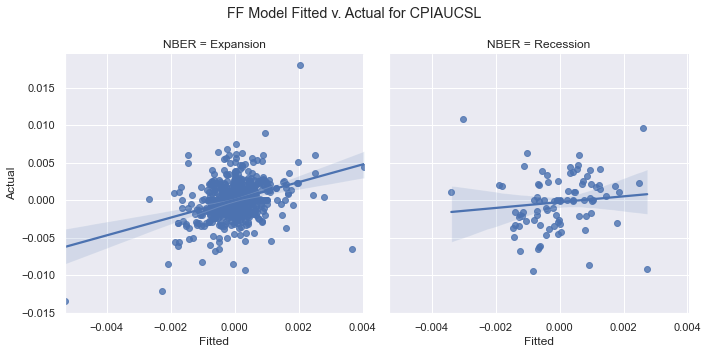

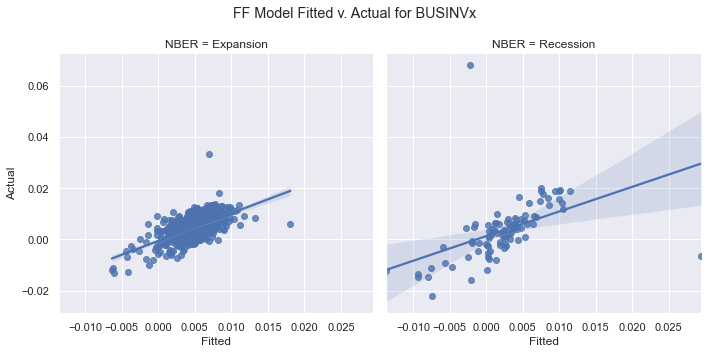

In [52]:
for s in my_srs:
    srs_data = pd.concat([fitted_values[s],
                         tfdata.loc[fitted_values[s].index,s],
                         NBER.loc[fitted_values[s].index]],axis=1).set_axis(
                             ['Fitted','Actual','NBER'],axis=1)
    sns.lmplot(data=srs_data, x='Fitted', y='Actual', col='NBER')
    plt.suptitle('FF Model Fitted v. Actual for '+s)
    plt.tight_layout()
    plt.savefig( s +'.pdf')
    plt.show()